## SIR
Here we simulate the evolution of a pandemic with the SIR model. <br>
Various actions are possible to the system, which learns the better policy through a reinforcement learning tecnique called NEAT.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class GSIR():
    
    def __init__(self, R0=2, gamma=0.5, N=60e+6, I=1, report=False):
        self.N = N               # Total number of people
        self.I0 = I              # Initial infective
        self.I = I               # Infective
        self.R = 0               # Recovered
        self.S = self.N - self.I # Susceptible
        self.int_ter = 152e+3    # Places in intensive terapy in hospitals
        
        self.beta0 = R0*gamma     # Initial infection rate
        self.gamma0 = gamma       # Initial recovering rate
        self.beta = R0*gamma      # Infection rate
        self.gamma = gamma        # Recovering rate
        self.chi = 0.05           # Knowing rate. The "system" knows only the worst
                                  # cases, 5%. Can be augmented with tests.
        self.old_chi = 0.05
        
        self.res_founds = 10       # Invest in research
        self.t_borders = 0        # Days from start of closure of borders
        self.t_quarantine = 0     # Days from start quarantine
        self.rew = 0              # Reward of the process
        self.num_ac = 11          # Number of possible actions from the system
        self.ac_report = np.zeros( self.num_ac )
        
        self.k = self.I*self.chi/self.N  # Known infected.
        self.O = [self.k, self.res_founds] # Observations known to the network
        self.report = report      # If true write on file the actions
        self.status = 'Running'   # Status of the system
        if self.report:
            self.writer = open('reporter.txt', 'w')
            self.evolution = [[self.beta], [gamma], [self.chi] ]
            self.Ss = []
            self.Is = []
            self.Rs = []
        
    def reset(self):
        self.__init__(N=self.N, I=self.I0, R0=self.beta0/self.gamma0, gamma=self.gamma0,
                     report=self.report)
                
    def SIR(self):
        dS = -self.beta*self.S*self.I/self.N
        dI = self.beta*self.S*self.I/self.N - self.gamma*self.I
        dR = self.gamma*self.I
        
        self.S += dS
        self.I += dI
        self.R += dR
        
    def action_sel(self, ac):
        ac = ac/ac.sum()                  # Normalization of the probabilities
        sorting = np.argsort(ac)          # Map between sorted ac and original ac
        ac = np.sort(ac)                  # Sorted ac
        u = np.random.rand()              # Random number to select the action 
        sel = np.searchsorted(ac, u)-1    # Selection of the action
        index = sorting[sel]              # Map to action number 
        return index
    
    def ac0(self):
        """ Do nothing """
        self.ac_report[0] += 1
        
    def ac1(self):
        """ Use minor protection, like mask and washing hands. No "rage" from people. """
        if self.ac_report[1] == 0:
            self.beta *= 0.9              # Arbitrary, to be determine from data
        self.ac_report[1] += 1
        
    def ac2(self):
        """ Close country frontiers. Small rage from people. """
        if self.ac_report[2] == 0:
            self.beta *= 0.8
            self.ac_report[2] += 1
        
    def ac3(self):
        """ Remove block on frontiers. """
        if self.ac_report[2] == 1:
            self.beta /= 0.8
            self.ac_report[2] -= 1
            self.t_borders = 0
        self.ac_report[3] += 1
            
    def ac4(self):
        """ Quarantine. Medium rage from people. """
        if self.ac_report[4] == 0:
            self.beta *= 0.5
            self.ac_report[4] += 1
            
    def ac5(self):
        """ Remove quarantine. """
        if self.ac_report[4] == 1:
            self.beta /= 0.5
            self.ac_report[4] -= 1       
            self.t_quarantine = 0
        self.ac_report[5] += 1
        
    def ac6(self):
        """ Selective quarantine. """
        if self.ac_report[6] == 0:
            self.beta *= (1-self.chi)
            self.old_chi = self.chi
            self.ac_report[6] += 1
            
    def ac7(self):
        """ Remove selective quarantine. """
        if self.ac_report[6] == 1:
            self.ac_report[6] -= 1
            self.beta /= (1-self.old_chi)
        self.ac_report[7] += 1
        
    def ac8(self):
        """ Invest in research. """
        self.res_founds += 1
        self.ac_report[8] += 1
        
    def ac9(self):
        """ Spend founds in tests. """
        if self.res_founds >= 5:
            self.res_founds -= 5
            self.chi /= 0.9       # Increase number of people visible from the system
        self.ac_report[9] += 1
        
    def ac10(self):
        """ Spend founds in better cure. """
        if self.res_founds >= 5:
            self.res_founds -= 5
            self.gamma /= 0.9    # Increase number of recovered people
        self.ac_report[10] += 1
        
#    def ac11(self):
#        """ For greater good. """
#        self.I -= chi*self.I    # Kill all the known infects
#        self.rew -= 5
        
    def _reward(self):
        if self.S >= 1:
            if self.ac_report[2] > 0: # Rage from closing the country
                self.rew -= (1 - np.exp(-0.005*self.t_borders) )
                self.t_borders += 1
            if self.ac_report[4] > 0: # Rage from quarantine
                self.rew -= (1 - np.exp(-0.01*self.t_quarantine) )
                self.t_quarantine += 1
            if self.I*0.05 >= self.int_ter:
                self.rew -= 10
            self.rew += 1 - self.I/self.N
            
    def _update(self, index):
        if   index == 0:  self.ac0()
        elif index == 1:  self.ac1() 
        elif index == 2:  self.ac2() 
        elif index == 3:  self.ac3() 
        elif index == 4:  self.ac4() 
        elif index == 5:  self.ac5() 
        elif index == 6:  self.ac6() 
        elif index == 7:  self.ac7() 
        elif index == 8:  self.ac8() 
        elif index == 9:  self.ac9() 
        elif index == 10: self.ac10() 
        elif index == 11: self.ac11() 
        
    def _upd_obs(self):
        self.k = (self.S*self.chi)/self.N  # Known infected-intensive ter beds.
        self.O = [self.k, self.res_founds] # Observations known to the network
    
    def _report(self, index, num):
        self.ac_des = ['00) Do nothing. \n', 
                       '01) Use minor protection, like mask and washing hands. \n',
                       '02) Close country borders. \n',
                       '03) Remove block on borders. \n',
                       '04) Imposing quarantine. \n',
                       '05) Remove quarantine. \n',
                       '06) Impose quarantine only on known infected. \n',
                       '07) Remove selective quarantine. \n',
                       '08) Invest in research. \n',
                       '09) Spend research founds in test. \n',
                       '10) Spend research founds in searching for a cure. \n',
                       '11) Kill all known infects. \n'
                      ]
        if num%3==0:
            self.writer.write(self.ac_des[index])
        self.evolution[0].append( self.beta )
        self.evolution[1].append( self.gamma )
        self.evolution[2].append( self.chi )
        self.Ss.append( self.S/env.N )
        self.Is.append( self.I/env.N )
        self.Rs.append( self.R/env.N )
        
    def close_rep(self):
        if self.report:
            self.writer.close()
    
    def step(self, actions):
        index = self.action_sel(actions)
        self._update(index)
        for _ in range(3):
            self.SIR()
            self._reward()
            self._upd_obs()
            if self.report: self._report(index, 3)
            
        if self.I < 1: self.status = 'Finished'
            

In [145]:
env = GSIR(R0=3, report=True)

np.random.seed(123)
env.reset()
ac = np.zeros(11)
ac[0]=1
for i in range(20):
    env.step(ac)
S0 = env.Ss
I0 = env.Is
R0 = env.Rs

env.reset()
ac = np.random.uniform(0,1, 11)
for i in range(20):
    env.step(ac)
S = env.Ss
I = env.Is
R = env.Rs

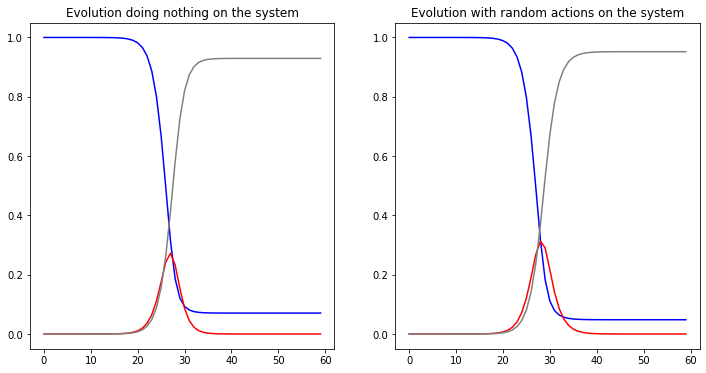

In [146]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].set_title('Evolution doing nothing on the system')
ax[0].plot(S0, color='blue')
ax[0].plot(I0, color='red')
ax[0].plot(R0, color='gray')

ax[1].set_title('Evolution with random actions on the system')
ax[1].plot(S, color='blue')
ax[1].plot(I, color='red')
ax[1].plot(R, color='gray')
plt.show()

Here starts the NEAT algorithm

In [7]:
from SaveLoadNet import load_object, save_object
from visualize import draw_net
import neat
import os

config_file = os.path.join('.', './../Config/config_gestional.txt')
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_file)

In [83]:
env = GSIR(I=10000, R0=3)

def eval_genomes(genomes, config):
    networks = [neat.nn.RecurrentNetwork.create(genome, config) for (genomeid, genome) in genomes]    
    obs = env.O
    rew = []
    T = 500
    dt = 3
    
    for net in networks:
        temp_rew = []
        env.reset()
        for _ in range(20):
            for i in range(T):
                actions = np.array( net.activate(obs) )
                env.step(actions)
                obs = env.O
                if env.status == 'Finished': break
                #if env.S > env.int_ter: break
            temp_rew.append( env.rew )
            env.reset()
            
        temp_rew = np.array(temp_rew)
        rew.append( temp_rew.mean()/(dt) )

    for i, (genomeid, genome) in enumerate(genomes):
            genome.fitness = rew[i]


    env.reset()

In [84]:
p = neat.Population(config)
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)
#p.add_reporter(neat.Checkpointer(5))
N_iter = 100
singol = p.run(eval_genomes, N_iter)


 ****** Running generation 0 ****** 

Population's average fitness: -13.68038 stdev: 6.97763
Best fitness: 25.64672 - size: (12, 24) - species 2 - id 200
Average adjusted fitness: 0.179
Mean genetic distance 2.501, standard deviation 0.328
Population of 250 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    59    -13.9    0.163     0
     2    0   191    -12.4    0.196     0
Total extinctions: 0
Generation time: 8.842 sec

 ****** Running generation 1 ****** 

Population's average fitness: -9.84068 stdev: 10.17304
Best fitness: 38.78311 - size: (12, 15) - species 2 - id 473
Average adjusted fitness: 0.191
Mean genetic distance 2.437, standard deviation 0.273
Population of 250 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    90    -10.9    0.180     0
     2    1   160     -9.5    0.202     0
Total extinctions: 0
Generation time: 9.924 sec (9.383

Population's average fitness: -0.16710 stdev: 15.68435
Best fitness: 38.29615 - size: (17, 11) - species 2 - id 4141
Average adjusted fitness: 0.362
Mean genetic distance 2.522, standard deviation 0.371
Population of 250 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   16    20     -2.4    0.328     2
     2   16    90      0.7    0.378     4
     3    7    33     -1.3    0.346     3
     4    5    94      1.7    0.396     0
     5    0    13       --       --     0
Total extinctions: 0
Generation time: 12.399 sec (12.074 average)

 ****** Running generation 17 ****** 



/Users/Marco/opt/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


Population's average fitness: 0.53600 stdev: 15.85084
Best fitness: 39.95701 - size: (16, 13) - species 4 - id 4389
Average adjusted fitness: 0.343
Mean genetic distance 2.551, standard deviation 0.400
Population of 249 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   17   112      4.3    0.416     3
     2   17    26      2.3    0.383     5
     3    8    43      0.6    0.355     4
     4    6    37     -1.0    0.330     1
     5    1    31     -6.9    0.232     0
Total extinctions: 0
Generation time: 12.581 sec (12.108 average)

 ****** Running generation 18 ****** 

Population's average fitness: 0.84254 stdev: 16.21362
Best fitness: 32.17083 - size: (15, 13) - species 1 - id 4567
Average adjusted fitness: 0.392
Mean genetic distance 2.563, standard deviation 0.430
Population of 250 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   18    51      2.3    0.

Population's average fitness: 1.92210 stdev: 17.54162
Best fitness: 28.87139 - size: (11, 3) - species 4 - id 7617
Average adjusted fitness: 0.430
Mean genetic distance 2.422, standard deviation 0.427
Population of 250 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   30    51     -0.3    0.390     2
     2   30    38     -0.5    0.386     1
     3   21    96      5.2    0.505    12
     4   19    22      2.0    0.438     6
     5   14    43      1.6    0.430    11
Total extinctions: 0
Generation time: 12.020 sec (12.353 average)

 ****** Running generation 31 ****** 

Population's average fitness: 3.70231 stdev: 17.91846
Best fitness: 28.75382 - size: (12, 4) - species 4 - id 7890
Average adjusted fitness: 0.468
Mean genetic distance 2.332, standard deviation 0.406
Population of 249 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   31    94      1.9    0.42

Population's average fitness: -0.02195 stdev: 18.40521
Best fitness: 29.59475 - size: (12, 3) - species 3 - id 10780
Average adjusted fitness: 0.408
Mean genetic distance 2.356, standard deviation 0.461
Population of 249 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   43   102      2.2    0.470     1
     2   43    24      7.1    0.564    14
     3   34    38     -1.4    0.399     9
     4   32    26     -4.2    0.346    12
     5   27    43     -0.1    0.425     4
     6    6    16     -9.6    0.242     1
Total extinctions: 0
Generation time: 10.300 sec (10.709 average)

 ****** Running generation 44 ****** 

Population's average fitness: 1.56888 stdev: 18.18579
Best fitness: 29.61674 - size: (13, 5) - species 1 - id 11153
Average adjusted fitness: 0.404
Mean genetic distance 2.315, standard deviation 0.466
Population of 250 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  ===

Population's average fitness: 2.80256 stdev: 19.14489
Best fitness: 29.75373 - size: (16, 7) - species 4 - id 13825
Average adjusted fitness: 0.426
Mean genetic distance 2.319, standard deviation 0.515
Population of 251 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   55    23      5.8    0.514    13
     2   55    11     -6.4    0.266    10
     3   46    36      3.3    0.463     6
     4   44    66      5.2    0.501     8
     5   39   107      3.5    0.467    16
     6   18     8     -2.4    0.347    10
Total extinctions: 0
Generation time: 11.485 sec (11.296 average)

 ****** Running generation 56 ****** 

Population's average fitness: -0.18008 stdev: 18.27543
Best fitness: 29.30573 - size: (11, 2) - species 5 - id 14140
Average adjusted fitness: 0.349
Mean genetic distance 2.396, standard deviation 0.567
Population of 249 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  ===

Population's average fitness: 1.93674 stdev: 18.52052
Best fitness: 29.92396 - size: (20, 14) - species 5 - id 16889

Species 4 with 49 members is stagnated: removing it
Average adjusted fitness: 0.428
Mean genetic distance 2.578, standard deviation 0.532
Population of 250 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     3   58    71      5.6    0.491    18
     5   51    50     -0.9    0.357     8
     7    4    51      0.8    0.391     2
     8    2    78      4.7    0.473     0
Total extinctions: 0
Generation time: 15.548 sec (12.057 average)

 ****** Running generation 68 ****** 

Population's average fitness: 0.90797 stdev: 18.19885
Best fitness: 30.16733 - size: (18, 4) - species 3 - id 17165
Average adjusted fitness: 0.389
Mean genetic distance 2.613, standard deviation 0.456
Population of 249 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     3   59    85   

Population's average fitness: 3.97188 stdev: 18.82803
Best fitness: 29.17963 - size: (20, 9) - species 7 - id 20280
Average adjusted fitness: 0.471
Mean genetic distance 2.877, standard deviation 0.442
Population of 250 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   65    23      4.2    0.493     3
     7   18    12     -4.9    0.310     6
     8   16    33      6.1    0.532     7
     9   12    20      4.4    0.497    11
    10    4    42      8.2    0.574     0
    11    1   120      0.5    0.418     0
Total extinctions: 0
Generation time: 12.823 sec (13.124 average)

 ****** Running generation 82 ****** 

Population's average fitness: 4.84138 stdev: 19.17381
Best fitness: 29.99634 - size: (19, 7) - species 8 - id 20690
Average adjusted fitness: 0.472
Mean genetic distance 2.861, standard deviation 0.468
Population of 249 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  ====

Mean genetic distance 2.756, standard deviation 0.391
Population of 249 members in 8 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   76    29      8.8    0.596     6
     7   29    15     -4.6    0.337    10
     8   27    35     -4.2    0.346    18
     9   23    65      7.1    0.563     5
    10   15    46     -5.7    0.317     3
    11   12    12      5.3    0.528     9
    12    7    22      9.1    0.602     5
    13    7    25      1.9    0.462     0
Total extinctions: 0
Generation time: 12.278 sec (12.605 average)

 ****** Running generation 93 ****** 

Population's average fitness: 6.21583 stdev: 18.96925
Best fitness: 29.74017 - size: (20, 6) - species 8 - id 23249
Average adjusted fitness: 0.511
Mean genetic distance 2.755, standard deviation 0.383
Population of 249 members in 8 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   77    15      7.4    0.544     7
     7   30 

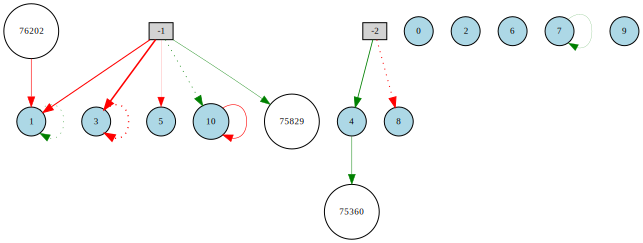

In [85]:
draw_net(config, singol)

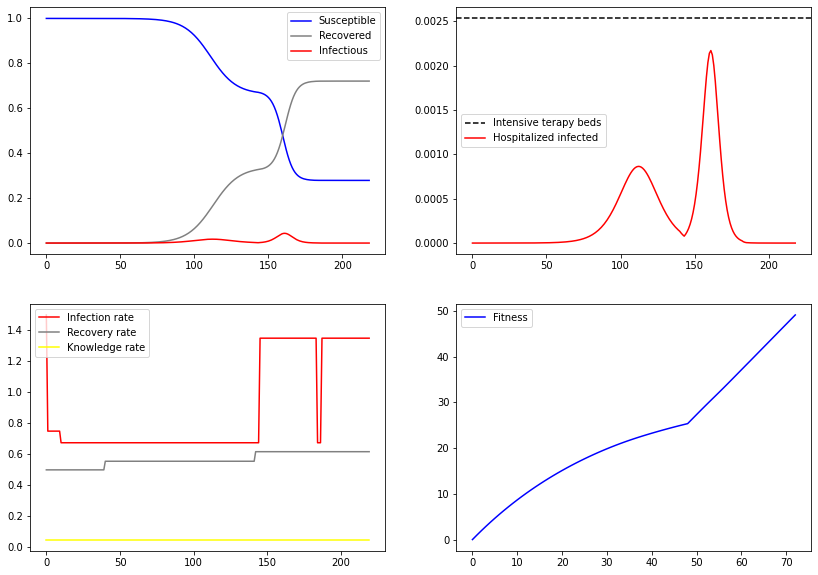

In [112]:
best_net = neat.nn.RecurrentNetwork.create(singol, config)
env = GSIR(report=True, R0=3)
obs = env.O
rew = []

T=200
dt=3

for i in range(T):
    rew.append( env.rew )
    actions = np.array( best_net.activate(obs) )
    env.step(actions)
    obs = env.O
    if env.status == 'Finished': break

S = np.array(env.Ss)
R = np.array(env.Rs)
I = np.array(env.Is)
ter = env.int_ter/env.N
        
fig, ax = plt.subplots(2, 2, figsize=(14,10) )
ax = ax.flatten()
ax[0].plot(S, color='blue', label= 'Susceptible')
ax[0].plot(R, color='gray', label= 'Recovered')
ax[0].plot(I, color='red', label= 'Infectious')
ax[0].legend()

ax[1].axhline(ter, ls='--', color='black', label= 'Intensive terapy beds')
ax[1].plot(I*0.05, color='red', label='Hospitalized infected')
ax[1].legend()

ax[2].plot( env.evolution[0], color='red', label='Infection rate')
ax[2].plot( env.evolution[1], color='gray', label='Recovery rate')
ax[2].plot( env.evolution[2], color='yellow', label='Knowledge rate')
#ax[2].plot(np.array(env.evolution[0])/np.array( env.evolution[1]), color='green', label='R0')
ax[2].legend()
#ax[2].set_xlim(0, 15)

ax[3].plot(np.array(rew)/(dt), color='blue', label='Fitness')
ax[3].legend()

plt.show()

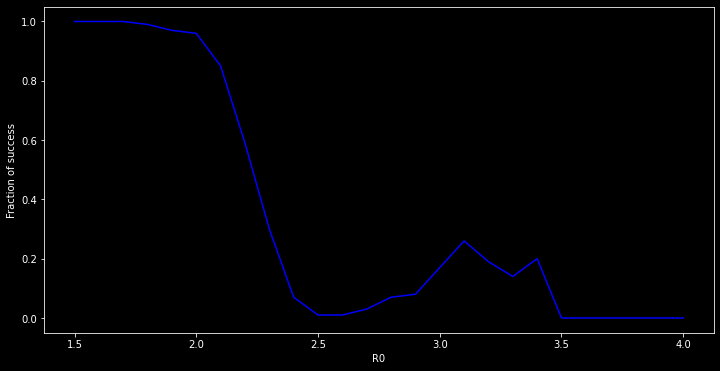

In [147]:
R0s = np.arange(1.5, 4.1, 0.1)
N = 100
success = np.zeros(len(R0s))
for i, r in enumerate(R0s):
    env = GSIR(report=True, R0=r)
    T=200
    dt=3
    for k in range(N):
        env.reset()
        obs = env.O
        for _ in range(T):
            actions = np.array( best_net.activate(obs) )
            env.step(actions)
            obs = env.O
            if env.status == 'Finished': break
        if max(env.Is)*0.05 < env.int_ter/env.N :
            success[i] += 1
success /= N

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(R0s, success, color='blue')
ax.set_xlabel('R0')
ax.set_ylabel('Fraction of success')
plt.show()